# Your First GAN
As a first experiment with generative adversarial networks, you’ll implement the example described in the previous section.

To run the example, you’re going to use the PyTorch library, which you can install using the Anaconda Python distribution and the conda package and environment management system. To learn more about Anaconda and conda, check out the tutorial on Setting Up Python for Machine Learning on Windows.

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

Here, you import the PyTorch library with torch. You also import nn just to be able to set up the neural networks in a less verbose way. Then you import math to obtain the value of the pi constant, and you import the Matplotlib plotting tools as plt as usual.

It’s a good practice to set up a random generator seed so that the experiment can be replicated identically on any machine. To do that in PyTorch, run the following code:

In [2]:
torch.manual_seed(111)

The number 111 represents the random seed used to initialize the random number generator, which is used to initialize the neural network’s weights. Despite the random nature of the experiment, it must provide the same results as long as the same seed is used.

Now that the environment is set, you can prepare the training data.

## Preparing the Training Data
The training data is composed of pairs (x₁, x₂) so that x₂ consists of the value of the sine of x₁ for x₁ in the interval from 0 to 2π. You can implement it as follows:

In [3]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

Here, you compose a training set with 1024 pairs (x₁, x₂). In line 2, you initialize train_data, a tensor with dimensions of 1024 rows and 2 columns, all containing zeros. A tensor is a multidimensional array similar to a NumPy array.

In line 3, you use the first column of train_data to store random values in the interval from 0 to 2π. Then, in line 4, you calculate the second column of the tensor as the sine of the first column.

Next, you’ll need a tensor of labels, which are required by PyTorch’s data loader. Since GANs make use of unsupervised learning techniques, the labels can be anything. They won’t be used, after all.

In line 5, you create train_labels, a tensor filled with zeros. Finally, in lines 6 to 8, you create train_set as a list of tuples, with each row of train_data and train_labels represented in each tuple as expected by PyTorch’s data loader.

You can examine the training data by plotting each point (x₁, x₂):

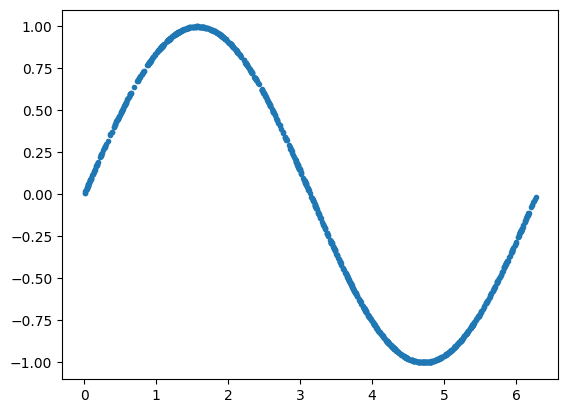

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

With train_set, you can create a PyTorch data loader:

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

Here, you create a data loader called train_loader, which will shuffle the data from train_set and return batches of 32 samples that you’ll use to train the neural networks.

After setting up the training data, you need to create the neural networks for the discriminator and generator that will compose the GAN. In the following section, you’ll implement the discriminator.

## Implementing the Discriminator
In PyTorch, the neural network models are represented by classes that inherit from nn.Module, so you’ll have to define a class to create the discriminator. For more information on defining classes, take a look at Object-Oriented Programming (OOP) in Python 3.

The discriminator is a model with a two-dimensional input and a one-dimensional output. It’ll receive a sample from the real data or from the generator and will provide the probability that the sample belongs to the real training data. The code below shows how to create a discriminator:

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

You use .__init__() to build the model. First, you need to call super().__init__() to run .__init__() from nn.Module. The discriminator you’re using is an MLP neural network defined in a sequential way using nn.Sequential(). It has the following characteristics:

* Lines 5 and 6: The input is two-dimensional, and the first hidden layer is composed of 256 neurons with ReLU activation.

* Lines 8, 9, 11, and 12: The second and third hidden layers are composed of 128 and 64 neurons, respectively, with ReLU activation.

* Lines 14 and 15: The output is composed of a single neuron with sigmoidal activation to represent a probability.

* Lines 7, 10, and 13: After the first, second, and third hidden layers, you use dropout to avoid overfitting.

Finally, you use .forward() to describe how the output of the model is calculated. Here, x represents the input of the model, which is a two-dimensional tensor. In this implementation, the output is obtained by feeding the input x to the model you’ve defined without any other processing.

After declaring the discriminator class, you should instantiate a Discriminator object:

In [7]:
discriminator = Discriminator()

discriminator represents an instance of the neural network you’ve defined and is ready to be trained. However, before you implement the training loop, your GAN also needs a generator. You’ll implement one in the next section.

## Implementing the Generator
In generative adversarial networks, the generator is the model that takes samples from a latent space as its input and generates data resembling the data in the training set. In this case, it’s a model with a two-dimensional input, which will receive random points (z₁, z₂), and a two-dimensional output that must provide (x̃₁, x̃₂) points resembling those from the training data.

The implementation is similar to what you did for the discriminator. First, you have to create a Generator class that inherits from nn.Module, defining the neural network architecture, and then you need instantiate a Generator object:

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

Here, generator represents the generator neural network. It’s composed of two hidden layers with 16 and 32 neurons, both with ReLU activation, and a linear activation layer with 2 neurons in the output. This way, the output will consist of a vector with two elements that can be any value ranging from negative infinity to infinity, which will represent (x̃₁, x̃₂).

Now that you’ve defined the models for the discriminator and generator, you’re ready to perform the training!

## Training the Models
Before training the models, you need to set up some parameters to use during training:

In [9]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

Here you set up the following parameters:

* Line 1 sets the learning rate (lr), which you’ll use to adapt the network weights.

* Line 2 sets the number of epochs (num_epochs), which defines how many repetitions of training using the whole training set will be performed.

* Line 3 assigns the variable loss_function to the binary cross-entropy function BCELoss(), which is the loss function that you’ll use to train the models.

The binary cross-entropy function is a suitable loss function for training the discriminator because it considers a binary classification task. It’s also suitable for training the generator since it feeds its output to the discriminator, which provides a binary observable output.

PyTorch implements various weight update rules for model training in torch.optim. You’ll use the Adam algorithm to train the discriminator and generator models. To create the optimizers using torch.optim, run the following lines:

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Finally, you need to implement a training loop in which training samples are fed to the models, and their weights are updated to minimize the loss function:

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.19106777012348175
Epoch: 0 Loss G.: 1.8886789083480835
Epoch: 10 Loss D.: 0.6593941450119019
Epoch: 10 Loss G.: 0.9345511198043823
Epoch: 20 Loss D.: 0.6652077436447144
Epoch: 20 Loss G.: 0.9237954616546631
Epoch: 30 Loss D.: 0.6530195474624634
Epoch: 30 Loss G.: 0.9662821292877197
Epoch: 40 Loss D.: 0.6457322835922241
Epoch: 40 Loss G.: 0.8339530825614929
Epoch: 50 Loss D.: 0.7044543027877808
Epoch: 50 Loss G.: 0.7268542647361755
Epoch: 60 Loss D.: 0.6701062321662903
Epoch: 60 Loss G.: 0.7226274609565735
Epoch: 70 Loss D.: 0.6060179471969604
Epoch: 70 Loss G.: 0.8528414964675903
Epoch: 80 Loss D.: 0.6869986057281494
Epoch: 80 Loss G.: 0.7439690232276917
Epoch: 90 Loss D.: 0.6611529588699341
Epoch: 90 Loss G.: 0.8209149837493896
Epoch: 100 Loss D.: 0.720684289932251
Epoch: 100 Loss G.: 0.6766296625137329
Epoch: 110 Loss D.: 0.7049028873443604
Epoch: 110 Loss G.: 0.6916813850402832
Epoch: 120 Loss D.: 0.6917641758918762
Epoch: 120 Loss G.: 0.6956319212913513
Epoch: 1

For GANs, you update the parameters of the discriminator and the generator at each training iteration. As is generally done for all neural networks, the training process consists of two loops, one for the training epochs and the other for the batches for each epoch. Inside the inner loop, you begin preparing the data to train the discriminator:

* Line 2: You get the real samples of the current batch from the data loader and assign them to real_samples. Notice that the first dimension of the tensor has the number of elements equal to batch_size. This is the standard way of organizing data in PyTorch, with each line of the tensor representing one sample from the batch.

* Line 4: You use torch.ones() to create labels with the value 1 for the real samples, and then you assign the labels to real_samples_labels.

* Lines 5 and 6: You create the generated samples by storing random data in latent_space_samples, which you then feed to the generator to obtain generated_samples.

* Line 7: You use torch.zeros() to assign the value 0 to the labels for the generated samples, and then you store the labels in generated_samples_labels.

* Lines 8 to 11: You concatenate the real and generated samples and labels and store them in all_samples and all_samples_labels, which you’ll use to train the discriminator.

Next, in lines 14 to 19, you train the discriminator:

* Line 14: In PyTorch, it’s necessary to clear the gradients at each training step to avoid accumulating them. You do this using .zero_grad().

* Line 15: You calculate the output of the discriminator using the training data in all_samples.

* Lines 16 and 17: You calculate the loss function using the output from the model in output_discriminator and the labels in all_samples_labels.

* Line 18: You calculate the gradients to update the weights with loss_discriminator.backward().

* Line 19: You update the discriminator weights by calling optimizer_discriminator.step().

Next, in line 22, you prepare the data to train the generator. You store random data in latent_space_samples, with a number of lines equal to batch_size. You use two columns since you’re providing two-dimensional data as input to the generator.

You train the generator in lines 25 to 32:

* Line 25: You clear the gradients with .zero_grad().

* Line 26: You feed the generator with latent_space_samples and store its output in generated_samples.

* Line 27: You feed the generator’s output into the discriminator and store its output in output_discriminator_generated, which you’ll use as the output of the whole model.

* Lines 28 to 30: You calculate the loss function using the output of the classification system stored in output_discriminator_generated and the labels in real_samples_labels, which are all equal to 1.

* Lines 31 and 32: You calculate the gradients and update the generator weights. Remember that when you trained the generator, you kept the discriminator weights frozen since you created optimizer_generator with its first argument equal to generator.parameters().

Finally, on lines 35 to 37, you display the values of the discriminator and generator loss functions at the end of each ten epochs.

Since the models used in this example have few parameters, the training will be complete in a few minutes. In the following section, you’ll use the trained GAN to generate some samples.

## Checking the Samples Generated by the GAN
Generative adversarial networks are designed to generate data. So, after the training process is finished, you can get some random samples from the latent space and feed them to the generator to obtain some generated samples:

In [12]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

Then you can plot the generated samples and check if they resemble the training data. Before plotting the generated_samples data, you’ll need to use .detach() to return a tensor from the PyTorch computational graph, which you’ll then use to calculate the gradients:

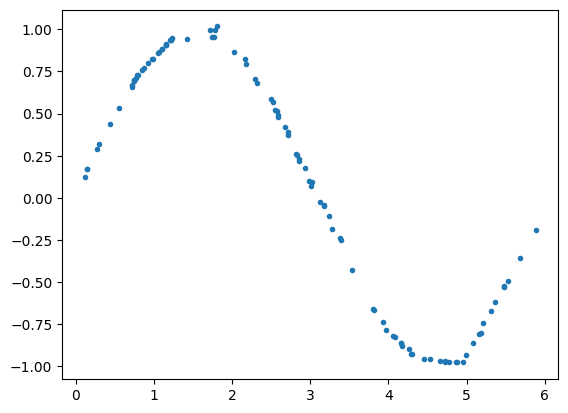

In [13]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

You can see the distribution of the generated data resembles the one from the real data. By using a fixed latent space samples tensor and feeding it to the generator at the end of each epoch during the training process, you can visualize the evolution of the training:

Note that at the beginning of the training process, the generated data distribution is very different from the real data. However, as the training progresses, the generator learns the real data distribution.

Now that you’ve done your first implementation of a generative adversarial network, you’ll go through a more practical application using images.

# Handwritten Digits Generator With a GAN
Generative adversarial networks can also generate high-dimensional samples such as images. In this example, you’re going to use a GAN to generate images of handwritten digits. For that, you’ll train the models using the MNIST dataset of handwritten digits, which is included in the torchvision package.

In [19]:
#!pip install chardet
#!pip install charset_normalizer==3.1.0

  Using cached charset_normalizer-3.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (199 kB)
  Attempting uninstall: charset_normalizer
    Found existing installation: charset-normalizer 2.0.4
    Uninstalling charset-normalizer-2.0.4:
      Successfully uninstalled charset-normalizer-2.0.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.14.5 requires fsspec[http]<2023.9.0,>=2023.1.0, but you have fsspec 2023.10.0 which is incompatible.


In [20]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [21]:
torch.manual_seed(111)

In [22]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Preparing the Training Data
The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, you’ll need to perform some conversions. For that, you define transform, a function to be used when loading the data:

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

The function has two parts:

1. transforms.ToTensor() converts the data to a PyTorch tensor.
2. transforms.Normalize() converts the range of the tensor coefficients.

The original coefficients given by transforms.ToTensor() range from 0 to 1, and since the image backgrounds are black, most of the coefficients are equal to 0 when they’re represented using this range.

transforms.Normalize() changes the range of the coefficients to -1 to 1 by subtracting 0.5 from the original coefficients and dividing the result by 0.5. With this transformation, the number of elements equal to 0 in the input samples is dramatically reduced, which helps in training the models.

The arguments of transforms.Normalize() are two tuples, (M₁, ..., Mₙ) and (S₁, ..., Sₙ), with n representing the number of channels of the images. Grayscale images such as those in MNIST dataset have only one channel, so the tuples have only one value. Then, for each channel i of the image, transforms.Normalize() subtracts Mᵢ from the coefficients and divides the result by Sᵢ.

Now you can load the training data using torchvision.datasets.MNIST and perform the conversions using transform:

In [24]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 9912422/9912422 [00:01<00:00, 6779351.93it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69023187.36it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 7655115.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12064932.72it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The argument download=True ensures that the first time you run the above code, the MNIST dataset will be downloaded and stored in the current directory, as indicated by the argument root.

Now that you’ve created train_set, you can create the data loader as you did before:

In [25]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

You can use Matplotlib to plot some samples of the training data. To improve the visualization, you can use cmap=gray_r to reverse the color map and plot the digits in black over a white background:

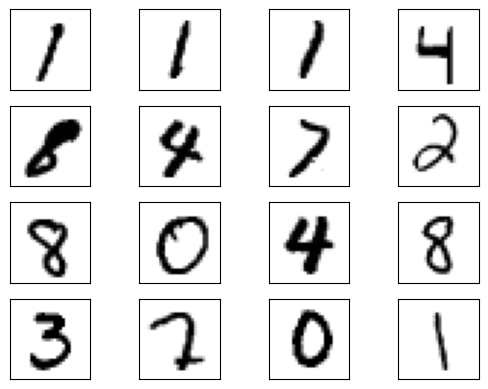

In [26]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

As you can see, there are digits with different handwriting styles. As the GAN learns the distribution of the data, it’ll also generate digits with different handwriting styles.

Now that you’ve prepared the training data, you can implement the discriminator and generator models.

## Implementing the Discriminator and the Generator
In this case, the discriminator is an MLP neural network that receives a 28 × 28 pixel image and provides the probability of the image belonging to the real training data.

You can define the model with the following code:

In [27]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients.

The vectorization occurs in the first line of .forward(), as the call to x.view() converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [28]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.

Here’s the complete generator model code:

In [29]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In line 12, you use the hyperbolic tangent function Tanh() as the activation of the output layer since the output coefficients should be in the interval from -1 to 1. In line 20, you instantiate the generator and send it to device to use the GPU if one is available.

Now that you have the models defined, you’ll train them using the training data.

## Training the Models
To train the models, you need to define the training parameters and optimizers like you did in the previous example:

In [32]:
lr = 0.0001
num_epochs = 5
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

To obtain a better result, you decrease the learning rate from the previous example. You also set the number of epochs to 50 to reduce the training time.

The training loop is very similar to the one you used in the previous example. In the highlighted lines, you send the training data to device to use the GPU if available:

In [33]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.03809288144111633
Epoch: 0 Loss G.: 5.501689910888672
Epoch: 1 Loss D.: 0.042991507798433304
Epoch: 1 Loss G.: 4.979561805725098
Epoch: 2 Loss D.: 0.012502206489443779
Epoch: 2 Loss G.: 5.523304462432861
Epoch: 3 Loss D.: 0.046231675893068314
Epoch: 3 Loss G.: 5.792187213897705
Epoch: 4 Loss D.: 0.022525101900100708
Epoch: 4 Loss G.: 4.43701171875


Some of the tensors don’t need to be sent to the GPU explicitly with device. This is the case with generated_samples in line 11, which will already be sent to an available GPU since latent_space_samples and generator were sent to the GPU previously.

Since this example features more complex models, the training may take a bit more time. After it finishes, you can check the results by generating some samples of handwritten digits.

## Checking the Samples Generated by the GAN
To generate handwritten digits, you have to take some random samples from the latent space and feed them to the generator:

In [34]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

To plot generated_samples, you need to move the data back to the CPU in case it’s running on the GPU. For that, you can simply call .cpu(). As you did previously, you also need to call .detach() before using Matplotlib to plot the data:

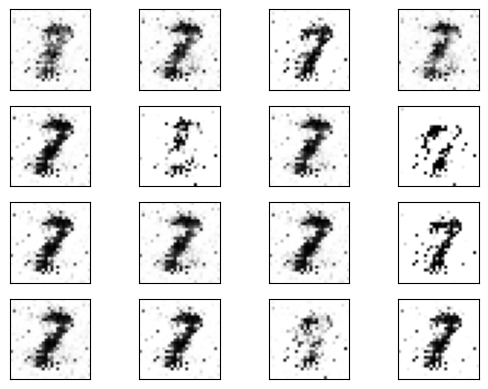

In [35]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])